# Spatio-Temporal-Action-Recognition with a CNN-RNN Architecture

**Training a action recognizer with transfer learning and a recurrent model on the UCF101 dataset.**

We will be using the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php)
to build our action recognizer. The dataset consists of videos categorized into different actions, like

1. cricket shot, 
2. punching, 
3. biking, etc. 

A video consists of an ordered sequence of frames. Each frame contains *spatial*
information, and the sequence of those frames contains *temporal* information. To model
both of these aspects, we use a hybrid architecture that consists of convolutions
(for spatial processing) as well as recurrent layers (for temporal processing).
Specifically, we'll use a Convolutional Neural Network (CNN) and a Recurrent Neural
Network (RNN) consisting of [GRU layers].

## Data collection

In order to make training time to low, we will be using a
subsampled version of the original UCF101 dataset. download the dataset from https://git.io/JGc31 link.

## Installing dependencies

In [4]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 5.2 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached libclang-14.0.1-py2.py3-none-manylinux1_x86_64.whl (14.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.5 MB/s eta 0:00:000:00:010:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=56a4e984fd2d127095ae12ab1d9b4794e5f3d754a3f91a16749fc2de7e99db6c
  Stored in directory: /home/aiml/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [6]:
!pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


In [8]:
!pip install matplotlib

  Using cached matplotlib-3.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.1/944.1 kB 79.1 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


## Importing Libraries

In [1]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Defining hyperparameters

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

## Data preprocessing

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
271,v_Punch_g12_c07.avi,Punch
588,v_TennisSwing_g25_c01.avi,TennisSwing
245,v_Punch_g09_c01.avi,Punch
43,v_CricketShot_g14_c02.avi,CricketShot
526,v_TennisSwing_g15_c02.avi,TennisSwing
103,v_CricketShot_g23_c05.avi,CricketShot
13,v_CricketShot_g09_c07.avi,CricketShot
201,v_PlayingCello_g20_c04.avi,PlayingCello
503,v_TennisSwing_g11_c07.avi,TennisSwing
317,v_Punch_g19_c05.avi,Punch


One of the many challenges of training action recognizer is figuring out a way to feed
the videos to a network. [This blog post](https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5)
discusses five such methods. Since a video is an ordered sequence of frames, we could
just extract the frames and put them in a 3D tensor. But the number of frames may differ
from video to video which would prevent us from stacking them into batches
(unless we use padding). As an alternative, we can **save video frames at a fixed
interval until a maximum frame count is reached**. In this example we will do
the following:

1. Capture the frames of a video.
2. Extract frames from the videos until a maximum frame count is reached.
3. In the case, where a video's frame count is lesser than the maximum frame count we
will pad the video with zeros.

In [4]:
# utility methods to read the frames from the video and make them to resize.
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

We can use a pre-trained network to extract meaningful features from the extracted
frames. The [`Keras Applications`](https://keras.io/api/applications/) module provides
a number of state-of-the-art models pre-trained on the [ImageNet-1k dataset](http://image-net.org/).
We will be using the [InceptionV3 model](https://arxiv.org/abs/1512.00567) for this purpose.

In [5]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

2022-07-13 16:24:35.834489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 16:24:35.856091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 16:24:35.856888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 16:24:35.858539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

The labels of the videos are strings. Neural networks do not understand string values,
so they must be converted to some numerical form before they are fed to the model. Here
we will use the [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer encode the class labels as integers.

In [6]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Finally, we can put all the pieces together to create our data processing utility.

In [7]:
def prepare_all_videos(df, root_dir):
    
    # total number of videos in the given dataset
    num_samples = len(df)
    
    # we took the paths of the videos in to list
    video_paths = df["video_name"].values.tolist()
    
    # we took the label of the videos in to list
    labels = df["tag"].values
    
    # encoding lables into numpy vectors like [[0],[0],[0],[0],[0]]...
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep (or) frames is masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    
    # frame features will be the features which is extracted for each frame
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
          
        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

2022-07-13 16:24:48.463121: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-07-13 16:24:49.136704: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step
Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like `GRU`.

In [10]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "./tmp/action_recognizer"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


train_performance, sequence_model = run_experiment()

Epoch 1/20
10/13 [======================>.......] - ETA: 0s - loss: 1.4702 - accuracy: 0.4094 
Epoch 1: val_loss improved from inf to 1.68555, saving model to ./tmp/action_recognizer
13/13 [==============================] - 4s 130ms/step - loss: 1.4587 - accuracy: 0.4024 - val_loss: 1.6856 - val_accuracy: 0.1564
Epoch 2/20
 6/13 [============>.................] - ETA: 0s - loss: 1.2965 - accuracy: 0.6302
Epoch 2: val_loss did not improve from 1.68555
13/13 [==============================] - 0s 10ms/step - loss: 1.2534 - accuracy: 0.6602 - val_loss: 1.6973 - val_accuracy: 0.0223
Epoch 3/20
10/13 [======================>.......] - ETA: 0s - loss: 1.1039 - accuracy: 0.7500
Epoch 3: val_loss improved from 1.68555 to 1.47532, saving model to ./tmp/action_recognizer
13/13 [==============================] - 0s 9ms/step - loss: 1.0906 - accuracy: 0.7663 - val_loss: 1.4753 - val_accuracy: 0.3408
Epoch 4/20
10/13 [======================>.......] - ETA: 0s - loss: 0.9621 - accuracy: 0.8375
Epoch 

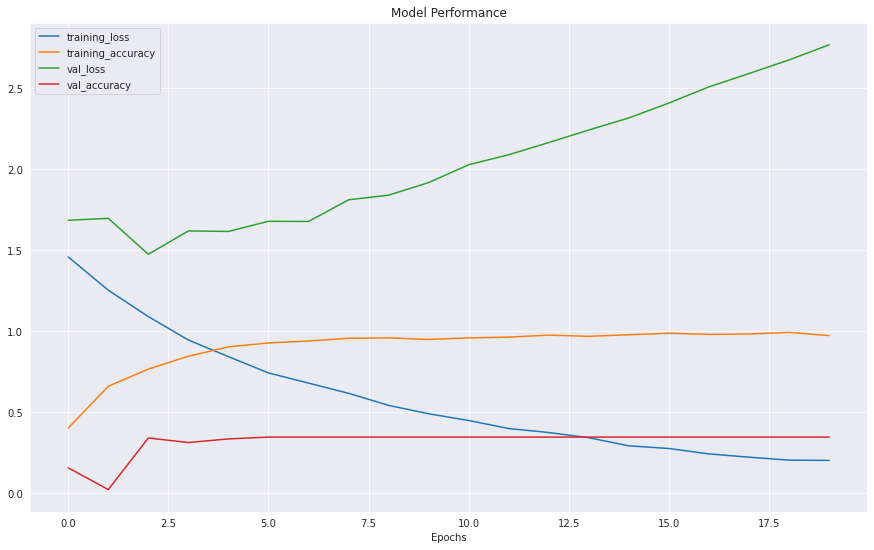

In [14]:
import seaborn as sns

plt.figure(figsize=(15, 9))
sns.set_style("darkgrid")
plt.plot(train_performance.history['loss'],label='training_loss')
plt.plot(train_performance.history['accuracy'],label='training_accuracy')
plt.plot(train_performance.history['val_loss'],label='val_loss')
plt.plot(train_performance.history['val_accuracy'],label='val_accuracy')
plt.xlabel("Epochs")
plt.legend(loc='upper left')
plt.title('Model Performance')
plt.show()

## Inference

Test video path: v_ShavingBeard_g02_c07.avi
1/1 [==============================] - 1s 1s/step
  ShavingBeard: 42.38%
  TennisSwing: 16.67%
  PlayingCello: 15.84%
  CricketShot: 13.08%
  Punch: 12.03%



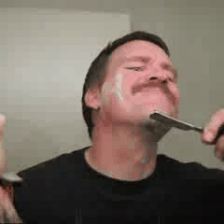

In [15]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

# This utility is for prediction.
def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])